In [2]:
import requests
from bs4 import BeautifulSoup

def get_rotowire_schedule(today=True):
    if today:
        url = "https://www.rotowire.com/baseball/daily-lineups.php"
    else:
        url = "https://www.rotowire.com/baseball/daily-lineups.php?date=tomorrow"

    response = requests.get(url)
    
    if response.status_code == 200:
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        lineup_boxes = soup.find_all("div", class_="lineup__box")
        game_times = soup.find_all("div", class_="lineup__time")
        return lineup_boxes, game_times
        #for box in lineup_boxes:
        #    content = box.get_text(strip=True)
        #    print(content)
    else:
        print(f"Failed to fetch webpage. Status code: {response.status_code}")


games, game_times = get_rotowire_schedule()


from importlib import reload
from src.simulation import Game as g
from src.simulation import Team as t
reload(g)
reload(t)

game = g.Game(games[0], game_times[0].get_text(strip=True) )

2024-05-26 10:43:49,902 - src.simulation.Game - INFO - Running init for TOR @ DET starting at 11:35 AM ET in Comerica Park
2024-05-26 10:43:49,902 - src.simulation.Game - INFO - Fitting hit classification model for Comerica Park
2024-05-26 10:43:58,223 - src.simulation.Game - INFO - Loading game state transition probs
2024-05-26 10:43:58,225 - src.simulation.Game - INFO - Fitting home team models
2024-05-26 10:43:58,263 - simulation.Pitcher - INFO - Starting init for Casey Mize
2024-05-26 10:44:13,780 - simulation.Pitcher - INFO - Casey Mize throws R with arsenal ['FF' 'SI' 'SL' 'KC' 'FS']
2024-05-26 10:44:13,780 - simulation.Pitcher - INFO - Init complete for Casey Mize
2024-05-26 10:44:13,814 - simulation.Batter - INFO - Starting init for Matt Vierling
2024-05-26 10:44:16,660 - simulation.Batter - INFO - Init complete for Matt Vierling
2024-05-26 10:44:16,693 - simulation.Batter - INFO - Starting init for Andy Ibanez
2024-05-26 10:44:20,327 - simulation.Batter - INFO - Init complete 

In [7]:
from pprint import pprint

def check_for_ab_event():
    if game.game_state.balls > 3:
        return 'walk'
    elif game.game_state.strikes > 2:
        return 'K'
    return None
    
def simulate_pitch(fielding_team, batting_team):

    if game.game_state.inning_is_top:
        batter_idx = game.game_state.away_cur_batter
    else:
        batter_idx = game.game_state.home_cur_batter
        
    
    cur_batter = batting_team.batting_lineup[batter_idx]
    cur_pitcher = fielding_team.starting_pitcher
    
    cur_game_state = game.game_state.get_game_state()

    #pitch_type, pitch_chars = cur_pitcher.generate_pitch(cur_game_state, cur_batter.stats, cur_pitcher.get_pitcher_state())
    pitch_type, pitch_chars = 'FF', {
        'release_speed': 91.5,
        'release_spin_rate': 2541.0,
        'release_extension': 6.3,
        'release_pos_x': -1.1,
        'release_pos_y': 54.2,
        'release_pos_z': 5.71,
        'spin_axis': 201.0,
        'pfx_x': -0.38,
        'pfx_z': 1.0,
        'vx0': 5.52946075120911,
        'vy0': -133.034107193298,
        'vz0': -5.81172219449376,
        'ax': -5.79249929698345,
        'ay': 31.1262248305161,
        'az': -19.2977353984413,
        'plate_x': 0.77,
        'plate_z': 1.91
    }
    pitch_outcome = cur_batter.generate_pitch_outcome(cur_game_state, pitch_chars)

    #print(f'{cur_pitcher.name} threw a {pitch_type} and {cur_batter.name} got a {pitch_outcome}')

    cur_pitcher.cumulative_pitch_number += 1
    cur_pitcher.prev_pitch = pitch_type
    game.game_state.pitch_number += 1

    #process pitch outcome
    if pitch_outcome == 'hit_into_play':
        hit_chars = cur_batter.generate_hit_outcome()
        #game_state, fielding_team_name, batter_speed, hit_stats, fielding_oaa
        hit_class = game.classify_hit(game.game_state.get_game_state(),
                                      fielding_team.name,
                                      cur_batter.speed,
                                      cur_batter.stand,
                                      hit_chars,
                                      0 #TODO ADD FIELDING OAA
                                     )
        return hit_class
        
    elif pitch_outcome == 'strike':
        game.game_state.strikes += 1
    elif pitch_outcome == 'ball':
        game.game_state.balls += 1
    elif pitch_outcome == 'foul':
        if game.game_state.strikes < 2:
            game.game_state.strikes += 1
    elif pitch_outcome == 'hit_by_pitch':
        game.game_state.balls = 4

    return check_for_ab_event()

def process_event(event, cur_batter, cur_pitcher):

    cur_game_state = game.game_state.encode_cur_state()
    
    if event in ('K', 'walk'):
        new_state = game.deterministic_transitions[event][cur_game_state]
        #print(f'{cur_batter.name} got a {event}')
    else:
        new_state = game.sample_next_state(event, cur_batter.stand, cur_game_state)
        #print(f'{cur_batter.name} hit a {event}')

    game.game_state.process_state_change(new_state, cur_batter)
    game.game_state.ab_change(cur_pitcher)

    #check if innning ended
    if game.game_state.outs > 2:
        game.game_state.change_inning()
        print(game.print_game_score())
        print(f'{'Top' if game.game_state.inning_is_top else 'Bot'} of the {game.game_state.inning}')

def simulate_ab(fielding_team, batting_team):
    game.game_state.reset_count()
    outcome = None
    while outcome is None:
        try:
            outcome = simulate_pitch(fielding_team, batting_team)
        except:
            print('Pitch sampling error')
        #outcome = simulate_pitch(fielding_team, batting_team)

    if game.game_state.inning_is_top:
        batter_idx = game.game_state.away_cur_batter
    else:
        batter_idx = game.game_state.home_cur_batter

    process_event(outcome, batting_team.batting_lineup[batter_idx], fielding_team.starting_pitcher)


In [13]:
scores_simmed = []
def run_game_sim():
    while game.game_state.inning != 6:
        if game.game_state.inning_is_top:
            simulate_ab(game.home_team, game.away_team)
        else:
            simulate_ab(game.away_team, game.home_team)
    return {'home_score':game.game_state.home_runs, 'away_score':game.game_state.away_runs}

In [15]:
import cProfile
import pstats

cProfile.run('run_game_sim()', 'profile_output')

with open('profile_output_no_pitch_gen.txt', 'w') as f:
    stats = pstats.Stats('profile_output', stream=f)
    stats.sort_stats('cumulative')
    stats.print_stats()


In [23]:
import pandas as pd
pd.DataFrame(scores_simmed)

,home_score,away_score
0,1,4
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
112,1,0
113,3,0
114,0,1
115,4,0


In [20]:
for i in range(100):
    scores_simmed.append(run_game_sim())
    game.game_state.reset_game()

AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Top of the 4
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Bot of the 4
AB CHANGE
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Top of the 5
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Bot of the 5
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Top of the 6
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Bot of the 1
AB CHANGE
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Top of the 2
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Bot of the 2
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
0-0 TOR-DET
None
Top of the 3
AB CHANGE
AB CHANGE
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
1-0 TOR-DET
None
Bot of the 3
AB CHANGE
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
1-1 TOR-DET
None
Top of the 4
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
1-1 TOR-DET
None
Bot of the 4
AB CHANGE
AB CHANGE
AB CHANGE
INNING CHANGE
1-1 TOR-DET
None
T

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(scores_simmed)

In [25]:
df['home_win'] = df['home_score'] > df['away_score']
df['away_win'] = df['home_score'] < df['away_score']
#df['tie'] = (df['home_score'] == df['away_score'])


In [58]:
df

,home_score,away_score,home_win,away_win
0,1,2,False,True
1,2,3,False,True
2,4,2,True,False
3,2,0,True,False
4,1,1,False,False
5,1,1,False,False
6,3,1,True,False
7,6,5,True,False
8,4,3,True,False
9,9,1,True,False


In [26]:
print(df['home_win'].mean())
print(df['away_win'].mean())
#df['tie'].mean()

0.3333333333333333
0.24786324786324787


In [61]:
game.away_team.name

'NYY'

In [27]:
df['total'] = df['home_score'] + df['away_score']

In [28]:
df['total'].mean()

1.4615384615384615

(array([68.,  0., 25.,  0.,  0., 13.,  0.,  9.,  0.,  2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

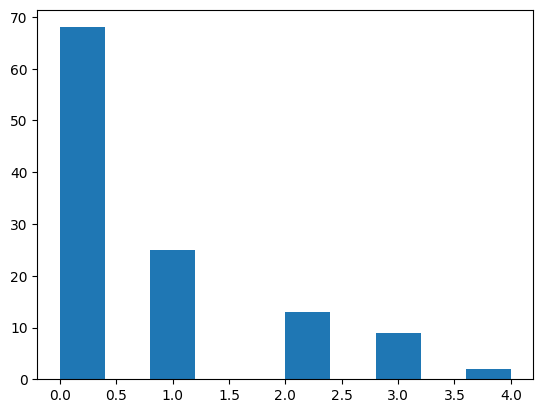

In [30]:
plt.hist(df['home_score'])

In [69]:
(df['total'] > 3.5).mean()

0.7666666666666667